<a href="https://colab.research.google.com/github/Ichin-0419/hp/blob/main/competition_2_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from sklearn.model_selection import StratifiedKFold  # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標

In [5]:
train = pd.read_csv("/content/drive/MyDrive/NFL_Draft_Prediction_train.csv")  # 学習用データの読み込み
test = pd.read_csv("/content/drive/MyDrive/NFL_Draft_Prediction_test.csv")
# 使わない列の削除
train = train.drop(columns=["Id", "School"])
test = test.drop(columns=["Id","School"])

for df in [train, test]:
  df['Age_isnull'] = df['Age'].isnull().astype(int)

for df in [train, test]:
  df['Sprint_40yd_isnull'] = df['Sprint_40yd'].isnull().astype(int)

# 平均で補完する対象の列
cols_to_fill = ['Age', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                'Broad_Jump', 'Agility_3cone', 'Shuttle']

# train の平均で train/test 両方を補完
for col in cols_to_fill:
    mean_value = train[col].mean()
    train[col] = train[col].fillna(mean_value)
    test[col] = test[col].fillna(mean_value)

    # カテゴリデータをラベルエンコーディング
label_encoders = {}
for c in ["Player_Type", "Position_Type", "Position"]:
    label_encoders[c] = LabelEncoder()
    train[c] = label_encoders[c].fit_transform(train[c].astype(str))
    test[c] = label_encoders[c].transform(test[c].astype(str))

#特徴量エンジニアリング
for df in [train, test]:
  df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

# モデルとCVの設定
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=2025
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# スコア・予測格納用
auc_scores = []
test_pred_proba_list = []

# Stratified K-Fold による学習と評価
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # モデル学習
    model.fit(X_train, y_train)

    # バリデーション予測 & スコア
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
    auc_scores.append(auc)
    print(f"  AUC: {round(auc, 4)}")

    # テストデータ予測を保存
    test_pred_proba = model.predict_proba(test)[:, 1]
    test_pred_proba_list.append(test_pred_proba)

# 平均AUCを表示
mean_auc = np.mean(auc_scores)
print("\nAverage Validation AUC:", round(mean_auc, 4))

# テスト予測の平均を計算
test_pred_proba_mean = np.mean(test_pred_proba_list, axis=0)


Fold 1
  AUC: 0.7888
Fold 2
  AUC: 0.8428
Fold 3
  AUC: 0.8455
Fold 4
  AUC: 0.7789
Fold 5
  AUC: 0.8391

Average Validation AUC: 0.819


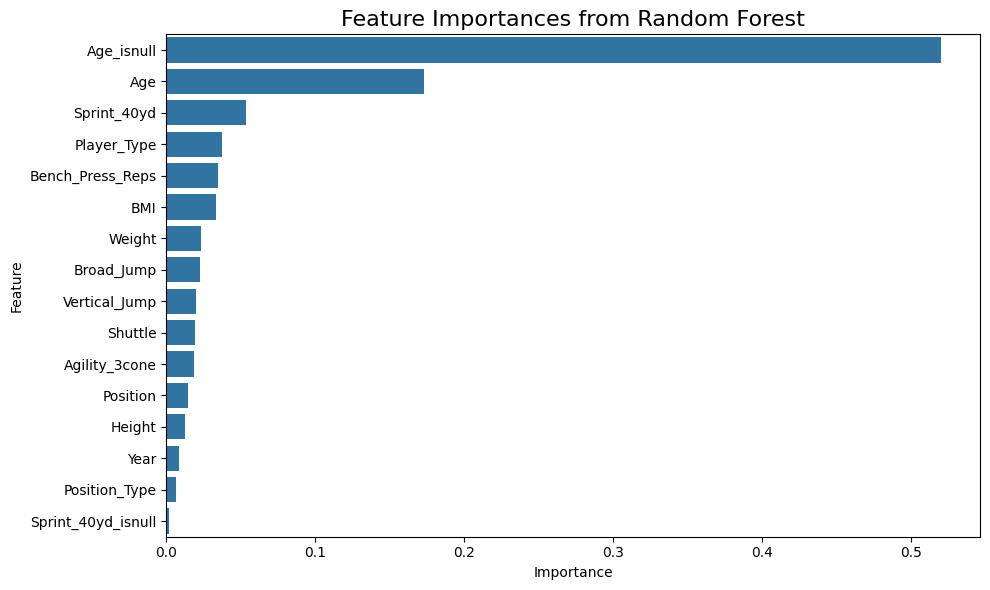

In [6]:
# 特徴量とその重要度をDataFrameにまとめる
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 可視化
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature')
plt.title('Feature Importances from Random Forest', fontsize=16)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [7]:
# このセルを実行すると提出用のCSVファイルが作成されます
"""submission = pd.read_csv("/content/drive/MyDrive/NFL_Draft_Prediction_sample_submission.csv") # PATHは必要に応じて変更の必要があります
submission["Drafted"] = test_pred_proba_mean
submission.to_csv("/content/drive/MyDrive/NFL_Draft_Prediction_baseline_submission.csv", index=False)"""

'submission = pd.read_csv("/content/drive/MyDrive/NFL_Draft_Prediction_sample_submission.csv") # PATHは必要に応じて変更の必要があります\nsubmission["Drafted"] = test_pred_proba_mean\nsubmission.to_csv("/content/drive/MyDrive/NFL_Draft_Prediction_baseline_submission.csv", index=False)'